#### 필요한 라이브러리 설치

In [3]:
! pip install torch torchvision clip-by-openai pillow clip torch


  Using cached clip_by_openai-1.1-py3-none-any.whl.metadata (369 bytes)
  Using cached clip-0.2.0.tar.gz (5.5 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      Traceback (most recent call last):
        File "c:\Users\LG\elice\.venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
        File "c:\Users\LG\elice\.venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
        File "c:\Users\LG\elice\.venv\lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 143, in get_requires_for_build_wheel
          return hook(config_settings)
        File "C:\Users\LG\AppData\Local\Temp\pip-build-env-qyf80qjw\overlay\Lib\site-packages\setuptools\build_meta.py", line 334, in get_requires_for_build_wheel
          return self._get_build_requires(config_settings, requirements=[])
        File "C:\Users\LG\Ap

In [5]:
! pip install git+https://github.com/openai/CLIP.git pillow

  Cloning https://github.com/openai/CLIP.git to c:\users\lg\appdata\local\temp\pip-req-build-_2kpjxrs
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369594 sha256=bb7232f3ff11923789e32e29c39176dbba0a0582d749b792bb114e3c774d5ef5
  Stored in directory: C:\Users\LG\AppData\Local\Temp\pip-ephem-wheel-cache-mgnz_web\wheels\da\2b\4c\d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\LG\AppData\Local\Temp\pip-req-build-_2kpjxrs'


In [6]:
! pip install clip

In [7]:
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

def preprocess_for_clip(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))

    # 선명도 보정
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(1.5)

    img_tensor = clip_preprocess(img).unsqueeze(0).to(device)
    return img_tensor


100%|███████████████████████████████████████| 338M/338M [00:41<00:00, 8.52MiB/s]


In [8]:
import clip
import torch
import numpy as np
from PIL import Image, ImageEnhance
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

# CLIP 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# 이미지 전처리 함수
def preprocess_for_clip(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))

    # 선명도 증가
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(1.5)

    return clip_preprocess(img).unsqueeze(0).to(device)

# 특징 벡터 추출 (한 번만 계산하여 캐싱)
def extract_clip_features(img_path):
    img_tensor = preprocess_for_clip(img_path)
    with torch.no_grad():
        features = clip_model.encode_image(img_tensor).cpu().numpy()
    return features.flatten()

# 유사도 계산 함수
def compute_clip_similarity(features1, features2):
    cos_sim = cosine_similarity([features1], [features2])[0][0]
    euclidean_dist = euclidean_distances([features1], [features2])[0][0]
    manhattan_dist = manhattan_distances([features1], [features2])[0][0]
    return cos_sim, euclidean_dist, manhattan_dist

# GAN 생성 이미지 & 추천 이미지 유사도 측정
def evaluate_similarities(gan_images, recommendation_images):
    # 특징 벡터 캐싱 (각 이미지당 1회만 계산)
    gan_features = {img: extract_clip_features(img) for img in gan_images}
    rec_features = {img: extract_clip_features(img) for img in recommendation_images}

    similarity_results = []

    # 반복문을 이용한 모든 조합 비교
    for gan_img, gan_vec in gan_features.items():
        for rec_img, rec_vec in rec_features.items():
            cos_sim, euclidean_dist, manhattan_dist = compute_clip_similarity(gan_vec, rec_vec)
            similarity_results.append({
                "GAN Image": gan_img,
                "Recommended Image": rec_img,
                "Cosine Similarity": cos_sim,
                "Euclidean Distance": euclidean_dist,
                "Manhattan Distance": manhattan_dist
            })

    return similarity_results

# 실행 예시
gan_img_paths = ["./ex_data/gan_1.png", "./ex_data/gan_2.png"]
re_img_paths = ["./ex_data/image_115.jpeg", "./ex_data/image_1.jpeg"]

results = evaluate_similarities(gan_img_paths, re_img_paths)

# 결과 출력
for res in results:
    print(res)


{'GAN Image': './ex_data/gan_1.png', 'Recommended Image': './ex_data/image_115.jpeg', 'Cosine Similarity': np.float32(0.7139076), 'Euclidean Distance': np.float32(8.113594), 'Manhattan Distance': np.float64(141.38753573875874)}
{'GAN Image': './ex_data/gan_1.png', 'Recommended Image': './ex_data/image_1.jpeg', 'Cosine Similarity': np.float32(0.6104609), 'Euclidean Distance': np.float32(9.562316), 'Manhattan Distance': np.float64(163.92572440672666)}
{'GAN Image': './ex_data/gan_2.png', 'Recommended Image': './ex_data/image_115.jpeg', 'Cosine Similarity': np.float32(0.6912339), 'Euclidean Distance': np.float32(8.680971), 'Manhattan Distance': np.float64(151.0080331992358)}
{'GAN Image': './ex_data/gan_2.png', 'Recommended Image': './ex_data/image_1.jpeg', 'Cosine Similarity': np.float32(0.80441827), 'Euclidean Distance': np.float32(6.9711566), 'Manhattan Distance': np.float64(125.99726561829448)}


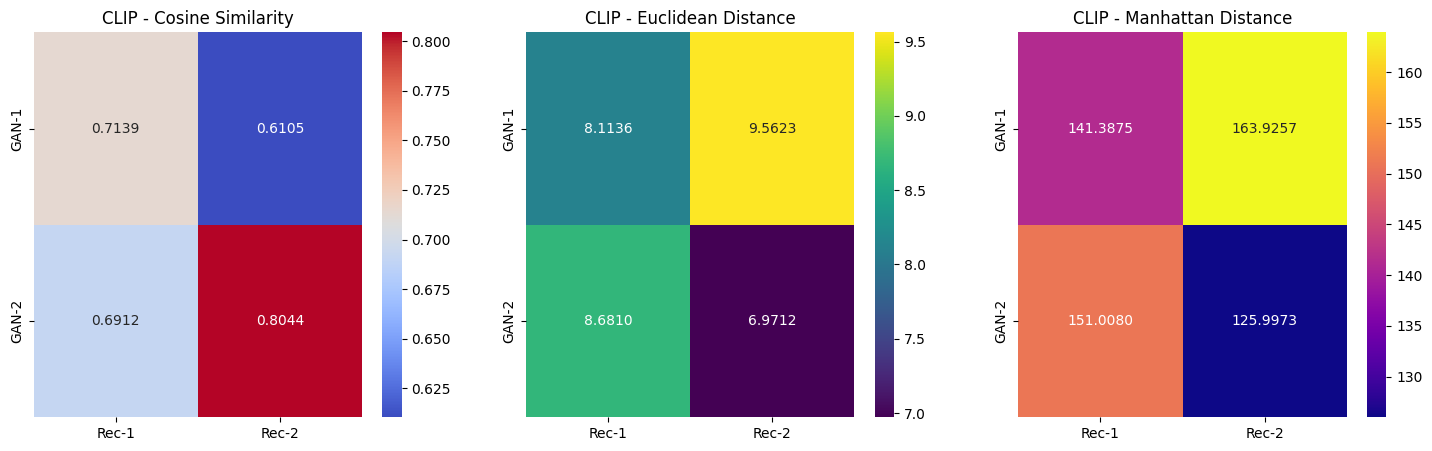

In [10]:
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageEnhance
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from itertools import product  # 모든 쌍을 자동으로 생성

# CLIP 모델 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# CLIP 전처리 (선명도 보정)
def preprocess_for_clip(img_path):
    img = Image.open(img_path).convert("RGB").resize((224, 224))

    # 선명도 증가
    enhancer = ImageEnhance.Sharpness(img)
    img = enhancer.enhance(1.5)

    return clip_preprocess(img).unsqueeze(0).to(device)

# CLIP 특징 벡터 추출
def extract_clip_features(img_path):
    img_tensor = preprocess_for_clip(img_path)
    with torch.no_grad():
        features = clip_model.encode_image(img_tensor).cpu().numpy()
    return features.flatten()

# 유사도 계산
def compute_similarity(vec1, vec2):
    return {
        "cosine_similarity": cosine_similarity([vec1], [vec2])[0][0],
        "euclidean_distance": euclidean_distances([vec1], [vec2])[0][0],
        "manhattan_distance": manhattan_distances([vec1], [vec2])[0][0]
    }

# CLIP 유사도 계산
def compute_clip_similarity(gan_img_paths, re_img_paths):
    feature_cache = {}  # 특징 벡터 저장 (중복 계산 방지)

    # 모든 이미지의 특징 벡터 추출 및 저장
    for img_path in gan_img_paths + re_img_paths:
        feature_cache[img_path] = extract_clip_features(img_path)

    # 모든 조합 비교 (GAN 이미지 ↔ 추천 이미지)
    similarity_results = {}
    for gan_img, re_img in product(gan_img_paths, re_img_paths):
        similarity_results[f"{gan_img} ↔ {re_img}"] = compute_similarity(feature_cache[gan_img], feature_cache[re_img])

    return similarity_results

# 유사도 시각화 (CLIP)
def plot_clip_similarity_heatmaps(similarity_results, gan_img_paths, re_img_paths):
    # 행렬을 만들기 위해 리스트 변환
    cosine_matrix = []
    euclidean_matrix = []
    manhattan_matrix = []

    for gan_img in gan_img_paths:
        cosine_row = []
        euclidean_row = []
        manhattan_row = []

        for re_img in re_img_paths:
            key = f"{gan_img} ↔ {re_img}"
            cosine_row.append(similarity_results[key]["cosine_similarity"])
            euclidean_row.append(similarity_results[key]["euclidean_distance"])
            manhattan_row.append(similarity_results[key]["manhattan_distance"])

        cosine_matrix.append(cosine_row)
        euclidean_matrix.append(euclidean_row)
        manhattan_matrix.append(manhattan_row)

    labels_x = [f"Rec-{i+1}" for i in range(len(re_img_paths))]
    labels_y = [f"GAN-{i+1}" for i in range(len(gan_img_paths))]

    # 히트맵 그리기
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    sns.heatmap(cosine_matrix, annot=True, fmt=".4f", cmap="coolwarm", xticklabels=labels_x, yticklabels=labels_y, ax=axes[0])
    axes[0].set_title("CLIP - Cosine Similarity")

    sns.heatmap(euclidean_matrix, annot=True, fmt=".4f", cmap="viridis", xticklabels=labels_x, yticklabels=labels_y, ax=axes[1])
    axes[1].set_title("CLIP - Euclidean Distance")

    sns.heatmap(manhattan_matrix, annot=True, fmt=".4f", cmap="plasma", xticklabels=labels_x, yticklabels=labels_y, ax=axes[2])
    axes[2].set_title("CLIP - Manhattan Distance")

    plt.show()

# 실행 예시
gan_img_paths = ["./ex_data/gan_1.png", "./ex_data/gan_2.png"]
re_img_paths = ["./ex_data/image_115.jpeg", "./ex_data/image_1.jpeg"]

# CLIP 유사도 계산 및 시각화
clip_similarity_results = compute_clip_similarity(gan_img_paths, re_img_paths)
plot_clip_similarity_heatmaps(clip_similarity_results, gan_img_paths, re_img_paths)
